In [33]:
import pandas as pd
data = pd.read_csv('kalimati_tarkari_dataset.csv')
data['Date'] =pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Period'] = data['Date'].dt.to_period('M').astype(str)
data = data[['Commodity','Period','Average']]

df = pd.pivot_table(data=data,values ='Average', index='Commodity', columns='Period',aggfunc='mean',fill_value=0)

## Dropping rows with null values

In [34]:
# Calculate percentage of zeros in each row
percent_zeros = (df == 0).sum(axis=1) / df.shape[1] * 100

# Add as a new column if you want to inspect
df['percent_zeros'] = percent_zeros
df_filtered = df[percent_zeros <=70].copy()

df_filtered.drop(columns=['percent_zeros'], inplace=True)


## Feature Engineering for Time Series Data

The data set is reshaped in the following way where:  
-n consecutive periods of demand as input  
-the demand of the very next period as output   


![dataset]("img/picture.png")

In [35]:
import numpy as np
def datasets(df, x_len=12, y_len=1, test_loops=12):
     D = df.values
     rows, periods = D.shape
     # Training set creation
     loops = periods + 1- x_len- y_len
     train = []
     for col in range(loops):
          train.append(D[:,col:col+x_len+y_len])
     train = np.vstack(train)
     X_train, Y_train = np.split(train,[-y_len],axis=1)
     # Test set creation
     if test_loops > 0:
        X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)
        Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
     else:
        X_test = D[:,-x_len:]
        Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value
     # Formatting required for scikit-learn
     if y_len == 1:
         Y_train = Y_train.ravel()
         Y_test = Y_test.ravel()
     return X_train, Y_train, X_test, Y_test

In [36]:
X_train, Y_train, X_test, Y_test = datasets(df_filtered, x_len=12, y_len=1, test_loops=12)

In [37]:
len(X_train)

6120

## Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg = reg.fit(X_train, Y_train)
Y_train_pred =reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

In [39]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    df = pd.DataFrame(columns =['MAE','RMSE', 'Bias'], index=['Train', 'Test'])
    df.index.name =name
    df.loc['Train', 'MAE'] = 100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)
    df.loc['Train','RMSE'] = 100*np.sqrt(np.mean((Y_train - Y_train_pred) ** 2))/np.mean(Y_train)
    df.loc['Train','Bias'] = 100*np.mean(Y_train-Y_train_pred)/np.mean(Y_train)
    df.loc['Test', 'MAE'] = 100*np.mean(abs(Y_test-Y_test_pred))/np.mean(Y_test)
    df.loc['Test','RMSE'] = 100*np.sqrt(np.mean((Y_test-Y_test_pred) ** 2))/np.mean(Y_test)
    df.loc['Test', 'Bias'] = 100 * np.mean(Y_test_pred - Y_test) / np.mean(Y_test)
    df = df.astype(float).round(3)
    return df

In [40]:
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Regression')

,MAE,RMSE,Bias
Regression,,,
Train,24.124,46.291,-0.000
Test,35.686,100.359,-6.454


## Decision Tree

In [41]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth =5, min_samples_split=25, min_samples_leaf =5, random_state=42)
tree.fit(X_train,Y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,25
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


max_depth : is the depth of tree, greater depth will lead to higher chance of overfitting  
min_samples_split : the min amount of samples that are required in a node to split the node, smaller the value higher chance of overfitting  
min_samples_leaf: the minimum amount of observations that need to be in the leaf. A closer value of 0 higher overfitting

In [42]:
 Y_train_pred = tree.predict(X_train)
 Y_test_pred = tree.predict(X_test)
 kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

,MAE,RMSE,Bias
Tree,,,
Train,24.069,43.329,-0.000
Test,36.889,92.874,-12.243


If we compare both regression tree vs. linear regression we realize the tree doesn't do much better on the training set with the random parameters we selected. 

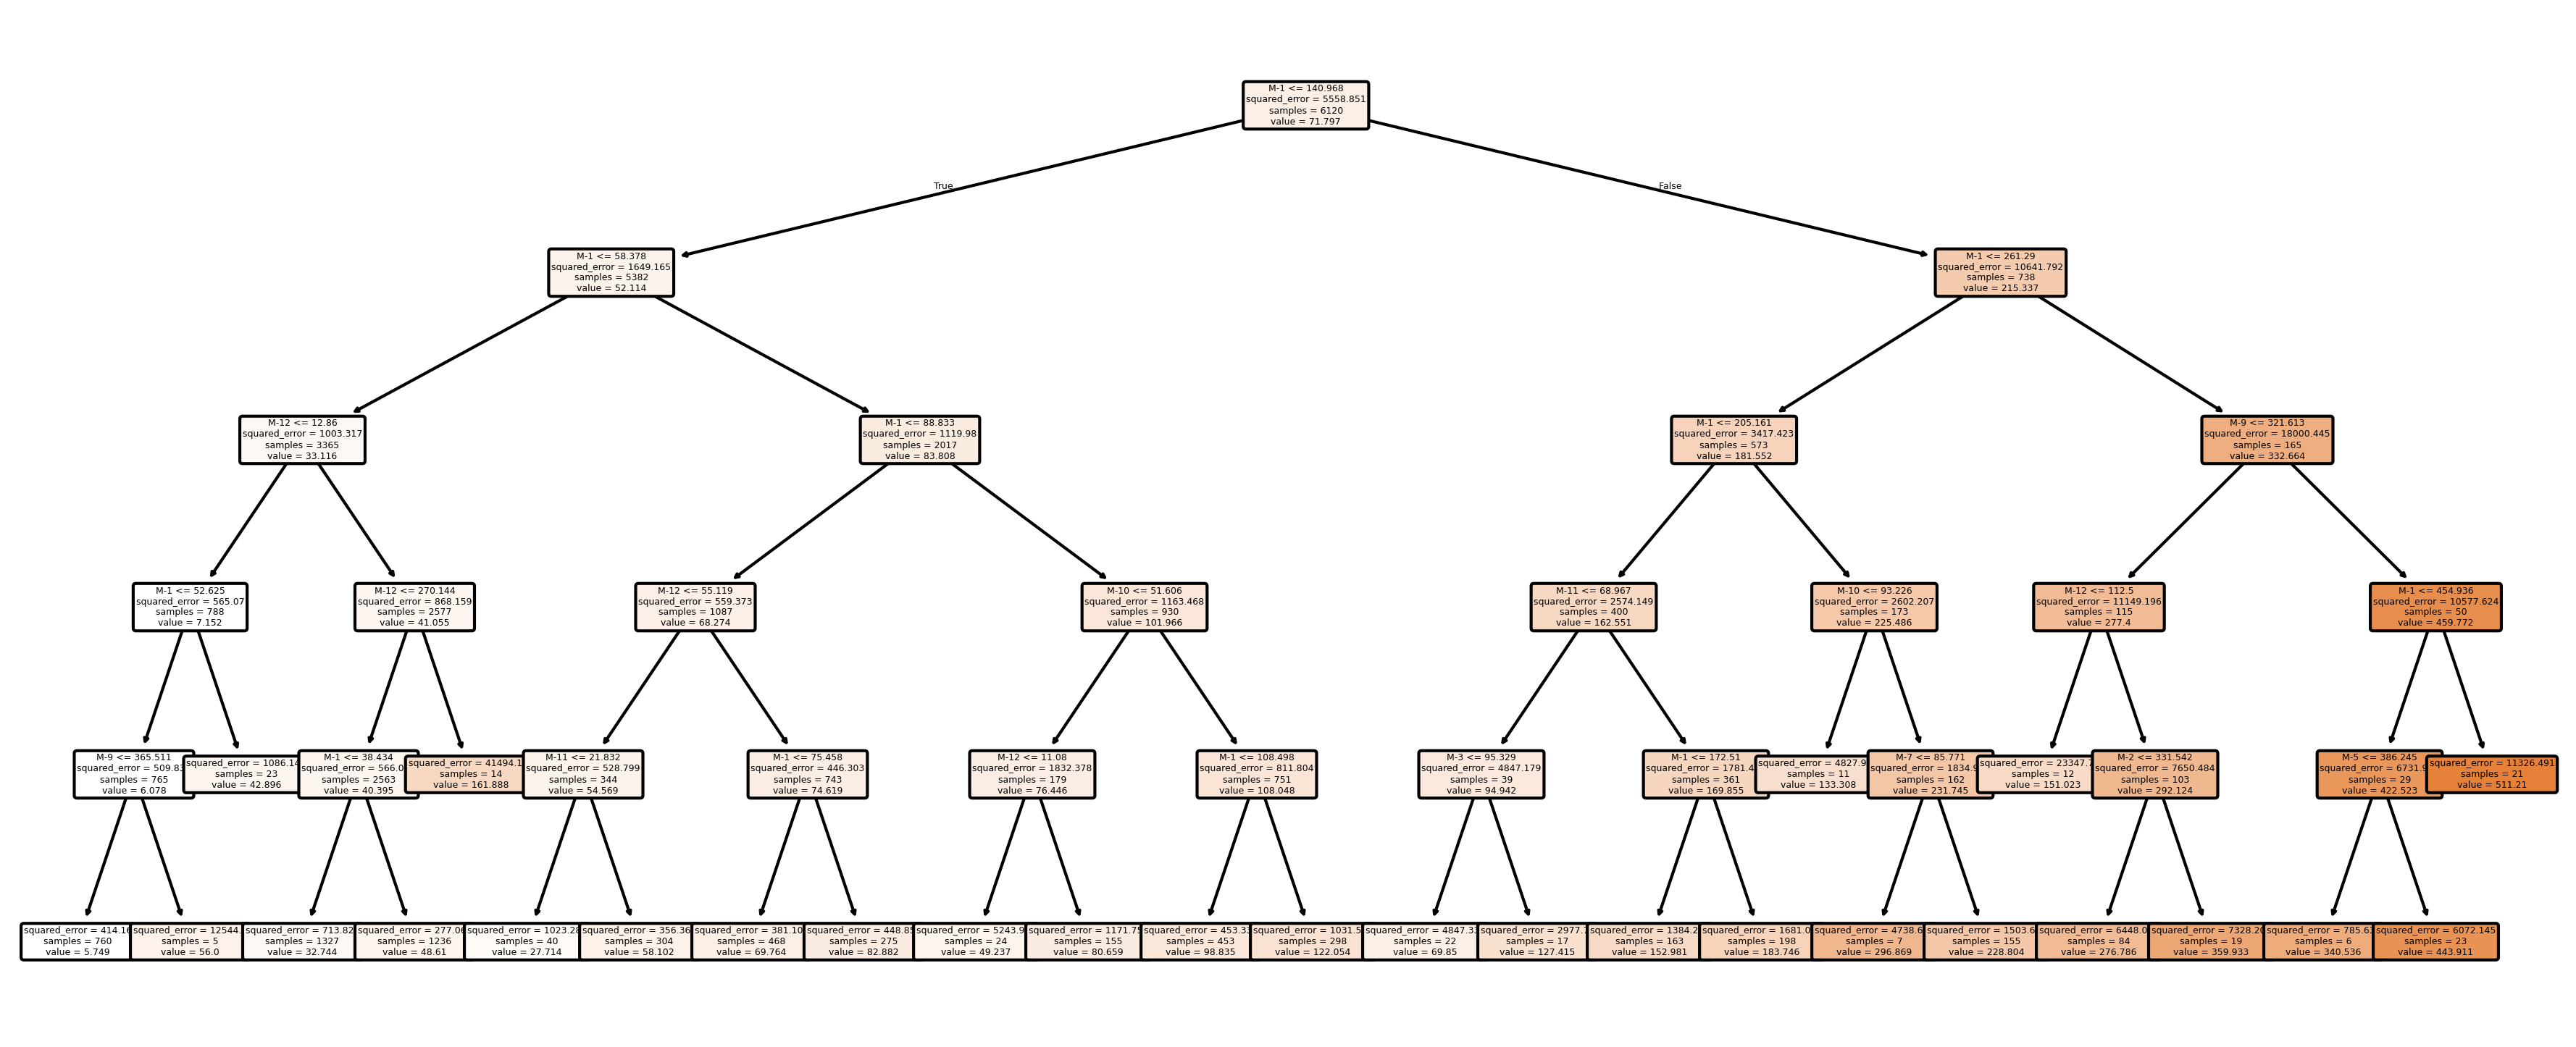

In [43]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize= (15,6), dpi=300)
ax = fig.gca()
plot_tree(tree, fontsize =3, feature_names=[f'M{x-12}' for x in range(12)], rounded=True, filled=True, ax=ax)
fig.savefig('Regression_Tree.PNG')

## Decision Tree with Randomized Cross Validation

K-fold Cross Validation to avoid overfitting  
Random Search to effeciently find a very good parameter set among different possibilities

n_jobs: nummber of processors that python will allocate to run this model  
cv: This is number of folds we want to create  
verbose: the higher the parameter more info  
n_iter: the number of parameter you want to test, higher number will test more parametersm but will be computationally more expensive  
scoring: This will give scoring parameter that will select the best model  

In [44]:
max_depth = list(range(5,11))+[None]
min_samples_split =range(5,20)
min_samples_leaf = range(2,20)
param_dist ={'max_depth':max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf
      }
from sklearn.model_selection import RandomizedSearchCV
tree =DecisionTreeRegressor( random_state=42)
tree_cv = RandomizedSearchCV(tree, param_dist, n_jobs =-1, cv=10, verbose=1, n_iter=100, scoring ='neg_mean_absolute_error')
tree_cv.fit(X_train, Y_train)
print('Tuned Regression Tree Parameters:',tree_cv.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned Regression Tree Parameters: {'min_samples_split': 10, 'min_samples_leaf': 19, 'max_depth': 6}


In [45]:
Y_train_pred = tree_cv.predict(X_train)
Y_test_pred = tree_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

,MAE,RMSE,Bias
Tree,,,
Train,22.87,43.232,-0.000
Test,37.42,91.396,-10.905


We can see that the train set as well as the test error has reduced because of the parameter optimization we do using 10 fold randomized cross validation.

## Ensemble Models

An ensemble model is a model constituted of many sub models.

bootstrap: This indicates if the random forest model will use bootstrapping  
max_features: The max amount of features that can be used at each tree to split a node, the lower the max feature more forests with higher variations  
n_estimators: The number of forests, the higher the better but computaionally expensive  
criterion: mse or mae



In [46]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(bootstrap =True, max_samples=0.95, max_features=11, min_samples_leaf=18, max_depth=7,random_state=42)
forest.fit(X_train, Y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,18
,min_weight_fraction_leaf,0.0
,max_features,11
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [47]:
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred,name='Forest')

,MAE,RMSE,Bias
Forest,,,
Train,21.237,41.861,-0.054
Test,35.435,89.601,-10.339


In [48]:
max_depth = list(range(5,20))+[None]
min_samples_split =range(5,20)
min_samples_leaf = range(2,20)
max_features =range(3,8)
bootstrap = [True]
max_samples=[0.7, 0.8, 0.9, 0.95,1]
param_dist ={'max_depth':max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'max_samples':max_samples,
      }
forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(forest, param_dist, n_jobs =-1, cv=6, verbose=2, n_iter=400, scoring ='neg_mean_absolute_error')
forest_cv.fit(X_train, Y_train)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits


,estimator,"RandomForestR...=30, n_jobs=1)"
,param_distributions,"{'bootstrap': [True], 'max_depth': [5, 6, ...], 'max_features': range(3, 8), 'max_samples': [0.7, 0.8, ...], ...}"
,n_iter,400
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,6
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [49]:
print('Tuned Forest Parameters:', forest_cv.best_params_)
print()
Y_train_pred =forest_cv.predict(X_train)
Y_test_pred =forest_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred,name='Forest optimized')


Tuned Forest Parameters: {'min_samples_split': 18, 'min_samples_leaf': 15, 'max_samples': 0.95, 'max_features': 7, 'max_depth': 9, 'bootstrap': True}



,MAE,RMSE,Bias
Forest optimized,,,
Train,20.544,40.863,-0.014
Test,35.491,89.050,-11.546


If we see in the optimized tree model the max_depth was 6 and in the optimized random forest model the max_depth is 15, deeper tree is more prone to overfit but gets compensated for by number of tress and the feature limitation.

There is computational trade-off between number of trees and accuracy of the model.

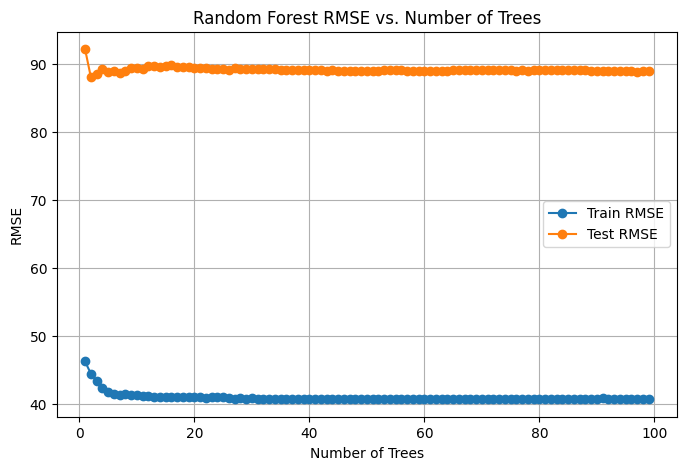

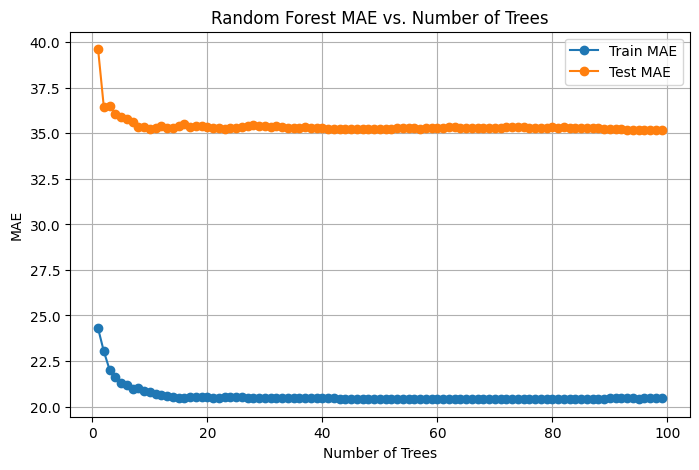

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# We'll store RMSE from kpi_ML
train_rmse = []
test_rmse = []
train_mae = []
test_mae = []
n_trees_range = range(1, 100, 1)  # 10, 30, ..., 190

for n_trees in n_trees_range:
    rf = RandomForestRegressor(n_estimators=n_trees, n_jobs=-1,**forest_cv.best_params_,random_state=42)
    rf.fit(X_train, Y_train)

    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    metrics_df = kpi_ML(Y_train, y_train_pred, Y_test, y_test_pred)
    train_mae.append(metrics_df.loc["Train", "MAE"])
    test_mae.append(metrics_df.loc["Test", "MAE"])
    train_rmse.append(metrics_df.loc["Train", "RMSE"])
    test_rmse.append(metrics_df.loc["Test", "RMSE"])

# Plot RMSE vs. Number of Trees
plt.figure(figsize=(8, 5))
plt.plot(n_trees_range, train_rmse, label="Train RMSE", marker='o')
plt.plot(n_trees_range, test_rmse, label="Test RMSE", marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Random Forest RMSE vs. Number of Trees")
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE vs. Number of Trees
plt.figure(figsize=(8, 5))
plt.plot(n_trees_range, train_mae, label="Train MAE", marker='o')
plt.plot(n_trees_range, test_mae, label="Test MAE", marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("MAE")
plt.title("Random Forest MAE vs. Number of Trees")
plt.legend()
plt.grid(True)
plt.show()


We can see no marked difference by increasing the number of trees on the random forest model and thus would consider 20 trees as a good estimate for the number of trees in the model. And if we compare our linear regression vs random forest model we can see approx 0.5% improvement in terms of MAE.

In [51]:
forest = RandomForestRegressor( n_estimators=20, **forest_cv.best_params_,random_state=42)
forest.fit(X_train, Y_train)
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred,name='Forest')

,MAE,RMSE,Bias
Forest,,,
Train,20.496,40.999,0.130
Test,35.331,89.489,-11.254


## Feature Importance

Though we can see statistically if there are trend in machine learning model,the came cannot be done in Machine Learning. Feature importance can be used to interpret the model. The questions like which months day had the highest importance and which months didn't matter. The importance of the feature is the reduction it brings to the objective that algorithm tries to minimize. Thus, it is defined as the accuracy brought by each feature.


<Axes: >

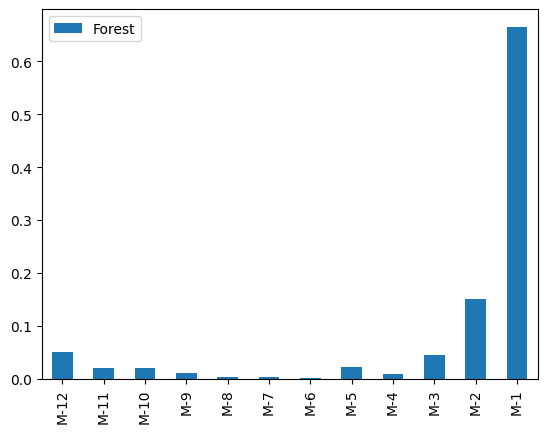

In [52]:
cols = X_train.shape[1] # number of columns in our training sets
features = [f'M-{cols-col}' for col in range(cols)]
data = forest.feature_importances_.reshape(-1,1)
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar')

We can see that M-1 is the most important month followed by M-2, M-3, M-11  

## Extremely Randomized Trees


In [53]:
from sklearn.ensemble import ExtraTreesRegressor
max_depth = list(range(5,20))+[None]
min_samples_split =range(5,20)
min_samples_leaf = range(2,20)
max_features =range(3,10)
bootstrap = [True]
max_samples=[0.7, 0.8, 0.9, 0.95,1]
param_dist ={'max_depth':max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'max_samples':max_samples,
      }
ETR = ExtraTreesRegressor(n_jobs=1, n_estimators=30,random_state=42)
ETR_cv = RandomizedSearchCV(ETR, param_dist, n_jobs =-1, cv=6, verbose=2, n_iter=400, scoring ='neg_mean_absolute_error')
ETR_cv.fit(X_train, Y_train)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits


,estimator,ExtraTreesReg...ndom_state=42)
,param_distributions,"{'bootstrap': [True], 'max_depth': [5, 6, ...], 'max_features': range(3, 10), 'max_samples': [0.7, 0.8, ...], ...}"
,n_iter,400
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,6
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [54]:
print('Tuned ETR Parameters:', ETR_cv.best_params_)
print()
Y_train_pred =ETR_cv.predict(X_train)
Y_test_pred =ETR_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred,name='ETR optimized')

Tuned ETR Parameters: {'min_samples_split': 18, 'min_samples_leaf': 2, 'max_samples': 0.8, 'max_features': 9, 'max_depth': 18, 'bootstrap': True}



,MAE,RMSE,Bias
ETR optimized,,,
Train,19.559,38.411,0.006
Test,35.813,90.484,-12.204


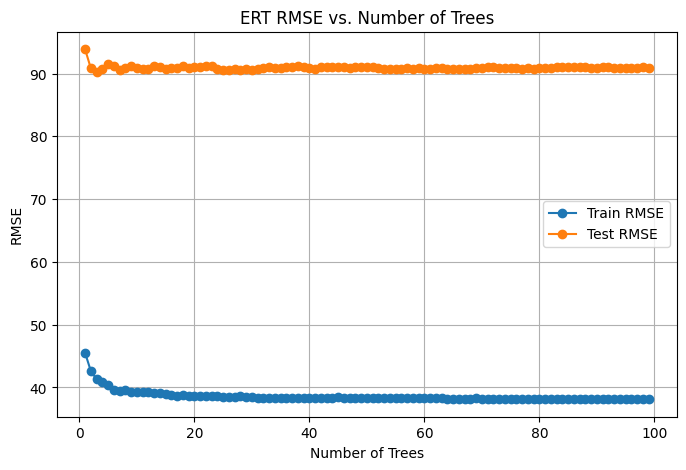

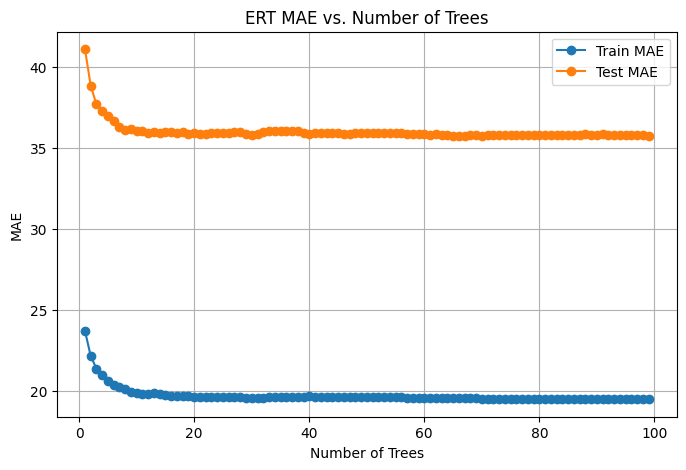

In [55]:
import numpy as np
import matplotlib.pyplot as plt
# We'll store RMSE from kpi_ML
train_rmse = []
test_rmse = []
train_mae = []
test_mae = []
n_trees_range = range(1, 100, 1)  # 10, 30, ..., 190

for n_trees in n_trees_range:
    ETR = ExtraTreesRegressor(n_estimators=n_trees, n_jobs=-1,**ETR_cv.best_params_,random_state=42)
    ETR.fit(X_train, Y_train)

    y_train_pred = ETR.predict(X_train)
    y_test_pred = ETR.predict(X_test)

    metrics_df = kpi_ML(Y_train, y_train_pred, Y_test, y_test_pred)
    train_mae.append(metrics_df.loc["Train", "MAE"])
    test_mae.append(metrics_df.loc["Test", "MAE"])
    train_rmse.append(metrics_df.loc["Train", "RMSE"])
    test_rmse.append(metrics_df.loc["Test", "RMSE"])

# Plot RMSE vs. Number of Trees
plt.figure(figsize=(8, 5))
plt.plot(n_trees_range, train_rmse, label="Train RMSE", marker='o')
plt.plot(n_trees_range, test_rmse, label="Test RMSE", marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("ERT RMSE vs. Number of Trees")
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE vs. Number of Trees
plt.figure(figsize=(8, 5))
plt.plot(n_trees_range, train_mae, label="Train MAE", marker='o')
plt.plot(n_trees_range, test_mae, label="Test MAE", marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("MAE")
plt.title("ERT MAE vs. Number of Trees")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
ERT = ExtraTreesRegressor( n_estimators=20, **ETR_cv.best_params_,random_state=42)
ERT.fit(X_train, Y_train)
Y_train_pred = ERT.predict(X_train)
Y_test_pred = ERT.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred,name='Forest')

,MAE,RMSE,Bias
Forest,,,
Train,19.640,38.658,0.146
Test,35.886,91.022,-12.973


## Feature Optimization 1

We can see that there is a very slight update in the MAE value and an increase in the MSE value, thus Extreme Randomized Tree doesn't make much of an impact as compared to the other model

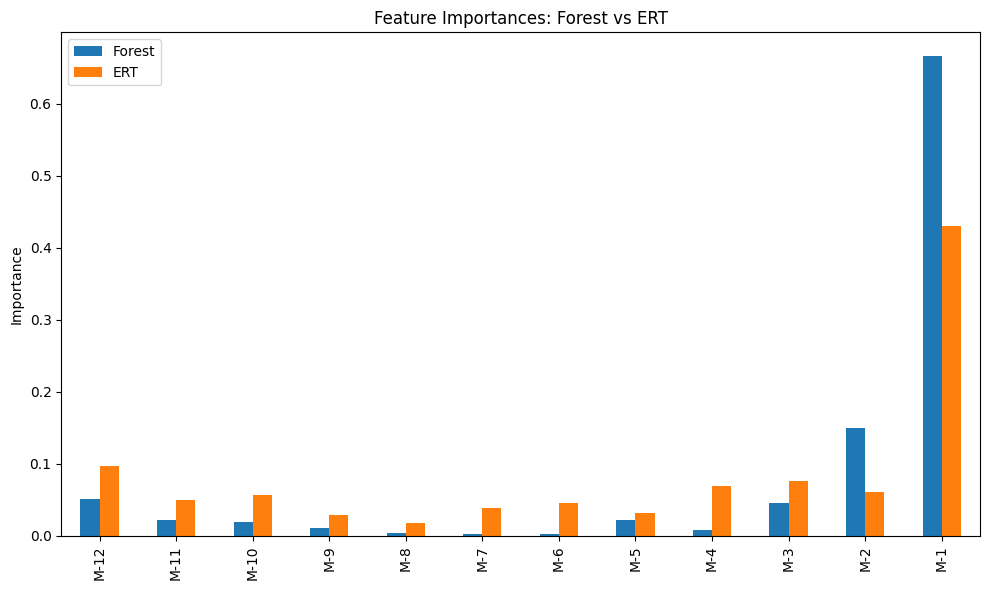

In [57]:
cols = X_train.shape[1]  # number of columns in our training sets
features = [f'M-{cols-col}' for col in range(cols)]

# Get feature importances
data_forest = forest.feature_importances_.reshape(-1, 1)
data_etr = ERT.feature_importances_.reshape(-1, 1)

# Combine into a single DataFrame
imp = pd.DataFrame(
    data=np.hstack([data_forest, data_etr]),
    index=features,
    columns=['Forest', 'ERT']
)

# Plot
imp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Importance')
plt.title('Feature Importances: Forest vs ERT')
plt.tight_layout()
plt.show()

The feature importance of ERT is much flatter as compared to the Random forest, the point of differnce between random forest and ERT is the way the node splits, as its not an optimal one but is selected only for certain ponts for each selected feature. Even if M-1 is the most important feature, its not true for all possible cases.  

 

### Experimentation-1

1. More input features means that the model learns more from then pattern created which means it also learns more from the noise leading to overfit.  
2. If we consider more months as feature we overall reduce the number of loops the feature engineering creates, leading to lesser data which also leads to overfit. 

In [58]:
df_filtered

Period,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,...,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05
Commodity,,,,,,,,,,,,,,,,,,,,,
Apple(Jholey),115.909091,108.400000,93.500000,95.100000,127.407407,130.729167,105.416667,99.375000,105.000000,104.886364,...,153.387097,145.666667,170.925926,236.956522,222.291667,203.548387,192.678571,190.000000,191.071429,248.333333
Arum,35.000000,31.660000,35.825000,37.500000,35.630435,37.543478,37.500000,37.520833,42.954545,40.659091,...,55.000000,59.333333,50.750000,53.793103,47.419355,52.419355,51.428571,53.250000,56.000000,55.000000
Asparagus,115.000000,133.541667,191.666667,229.583333,249.130435,341.666667,0.000000,0.000000,0.000000,411.458333,...,454.642857,427.222222,1900.000000,0.000000,0.000000,265.000000,0.000000,772.222222,535.833333,744.230769
Bakula,0.000000,0.000000,0.000000,95.000000,84.375000,87.708333,67.083333,47.750000,36.568182,35.363636,...,110.000000,0.000000,0.000000,106.250000,107.741935,102.258065,105.357143,61.000000,81.400000,0.000000
Bamboo Shoot,56.818182,73.900000,64.047619,66.300000,55.370370,67.916667,125.000000,148.125000,153.636364,154.545455,...,103.387097,95.000000,92.931034,85.000000,82.096774,77.258065,75.000000,75.000000,93.000000,95.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomato Big(Nepali),30.227273,54.700000,43.523810,40.300000,50.462963,83.854167,51.250000,35.833333,32.000000,36.340909,...,74.318182,92.586207,61.739130,66.250000,62.983871,46.500000,50.277778,46.346154,53.125000,42.916667
Tomato Small(Local),23.636364,35.360000,31.523810,39.580000,52.685185,61.173913,31.375000,27.583333,30.630435,43.818182,...,47.500000,68.333333,60.322581,44.833333,46.693548,22.403226,16.250000,27.200000,24.583333,18.653846
Turnip A,47.272727,47.500000,0.000000,0.000000,51.785714,53.409091,46.326087,39.708333,32.976190,32.931818,...,81.666667,67.000000,79.537037,66.944444,75.322581,75.000000,75.000000,75.000000,75.000000,65.000000


In [59]:
E_Parameters={'min_samples_split': 16, 'min_samples_leaf': 2, 'max_samples': 0.95, 'max_features': 9, 'max_depth': 19, 'bootstrap': True, 'n_jobs':-1,  'n_estimators':20}
F_Parameters= {'min_samples_split': 6, 'min_samples_leaf': 13, 'max_samples': 0.95, 'max_features': 7, 'max_depth': 10, 'bootstrap': True,'n_jobs':-1,  'n_estimators':20}

In [60]:
forest = RandomForestRegressor(**F_Parameters)
ETR = ExtraTreesRegressor(**E_Parameters)

models =[('Forest', forest),('ETR',ETR)]

In [61]:
def model_mae(model, X,Y):
    Y_pred = model.predict(X)
    mae =np.mean(np.abs(Y-Y_pred))/np.mean(Y)
    return mae
n_months =range(6,50,2)
results = []
for x_len in n_months:
    X_train, Y_train, X_test, Y_test = datasets(df_filtered, x_len=x_len)
    for name, model in models:
        model.fit(X_train, Y_train)
        mae_train = model_mae(model, X_train, Y_train)
        mae_test = model_mae(model, X_test, Y_test)
        results.append([name+'Train', mae_train, x_len])
        results.append([name+'Test', mae_test, x_len])

In [62]:
data = pd.DataFrame(results, columns=['Model', 'Mae%', 'Number of Months'])
data=data.set_index(['Number of Months', 'Model']).stack().unstack('Model')
data.index =data.index.droplevel(level=1)
data.index.name ="Number of months"


<Axes: xlabel='Number of months'>

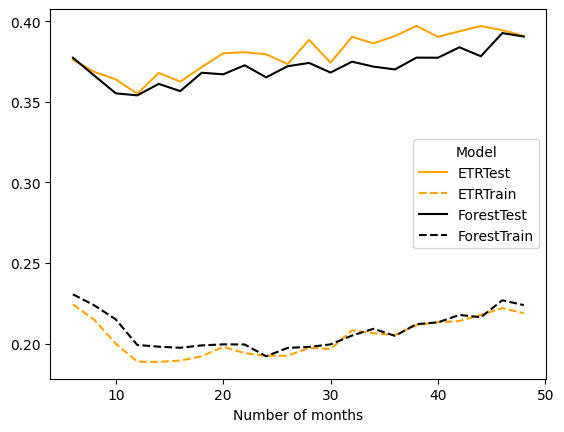

In [63]:
data.plot(color=['orange']*2+['black']*2,style=['-','--']*2)


### Experimentation-2

Use high value of k-folds to reduce the results randomness. A higher number of k-folds will also limit the reduced amount of data for our model to learn from, on the other hand we use more k-folds, the computation time explodes.

In [64]:
from sklearn.model_selection import KFold
results = []
for x_len in n_months:
    X_train, Y_train, X_test, Y_test = datasets(df_filtered, x_len=x_len)
    for name, model in models:
        mae_kfold_train =[]
        mae_kfold_val =[]
        for train_index, val_index in KFold(n_splits=8).split(X_train):
             X_train_kfold, X_val_kfold =X_train[train_index], X_train[val_index]
             Y_train_kfold, Y_val_kfold =Y_train[train_index], Y_train[val_index]
             model.fit(X_train_kfold,Y_train_kfold)
             mae_train = model_mae(model, X_train_kfold, Y_train_kfold)
             mae_kfold_train.append(mae_train)
             mae_val = model_mae(model, X_val_kfold, Y_val_kfold)
             mae_kfold_val.append(mae_val)
        results.append([name+'Val', np.mean(mae_kfold_val), x_len])
        results.append([name+'Train', np.mean(mae_kfold_train), x_len])    
        model.fit(X_train, Y_train)
        mae_test = model_mae(model, X_test, Y_test)
        results.append([name+'Test', mae_test, x_len])

In [65]:
results

[['ForestVal', 0.26565226097547195, 6],
 ['ForestTrain', 0.2298008635575059, 6],
 ['ForestTest', 0.3757063902492981, 6],
 ['ETRVal', 0.26505098725295506, 6],
 ['ETRTrain', 0.22350350444584227, 6],
 ['ETRTest', 0.3746607759279054, 6],
 ['ForestVal', 0.26193443488453066, 8],
 ['ForestTrain', 0.2232448011893776, 8],
 ['ForestTest', 0.36708459373577446, 8],
 ['ETRVal', 0.26299887848756587, 8],
 ['ETRTrain', 0.2153675481598902, 8],
 ['ETRTest', 0.36465458584672245, 8],
 ['ForestVal', 0.2528494372575969, 10],
 ['ForestTrain', 0.21475220182031446, 10],
 ['ForestTest', 0.35547084100336945, 10],
 ['ETRVal', 0.25014229404271227, 10],
 ['ETRTrain', 0.20273826517156657, 10],
 ['ETRTest', 0.36239823474277627, 10],
 ['ForestVal', 0.23602213529168983, 12],
 ['ForestTrain', 0.19959676070321836, 12],
 ['ForestTest', 0.3567491706108378, 12],
 ['ETRVal', 0.23820822228477573, 12],
 ['ETRTrain', 0.18953811514681945, 12],
 ['ETRTest', 0.35401688179350943, 12],
 ['ForestVal', 0.23815257711000115, 14],
 ['For

Model
ETRTest        12
ETRTrain       16
ETRVal         12
ForestTest     14
ForestTrain    24
ForestVal      12
dtype: int64


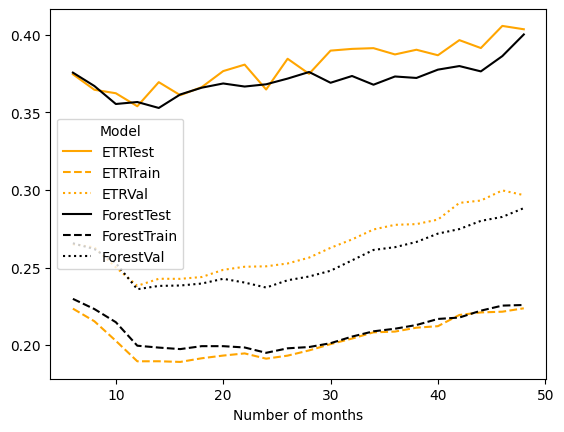

In [66]:
data = pd.DataFrame(results,columns=['Model','MAE%','Number of Months'])
data = data.set_index(['Number of Months','Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of months'
data.plot(color=['orange']*3+['black']*3,style=['-','--',':']*2)
print(data.idxmin())


### Experimentation-3

1. The error in the validation set seems to decrease as the number of months increases.
2. The hold out set behaves similar to the test set.

In [67]:
def datasets_holdout(df, x_len=12, y_len=1, test_loops =12, holdout_loops=0):
    D= df.values
    rows, periods = D.shape
    train_loops = periods+1-x_len-y_len-test_loops
    train = []
    for col in range(train_loops):
        train.append(D[:, col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train,[-y_len],axis=1)
    if holdout_loops >0:
        X_train, X_holdout = np.split(X_train, [-rows*holdout_loops], axis =0)
        Y_train, Y_holdout = np.split(Y_train, [-rows*holdout_loops], axis =0)
    else:
        X_holdout, Y_holdout = np.array([]), np.array([])
    if test_loops>0:
        X_train, X_test =np.split(X_train, [-rows*test_loops], axis=0)
        Y_train, Y_test =np.split(Y_train, [-rows*test_loops], axis=0)
    else:
        X_test = D[:, -x_len:]
        Y_test = np.full((X_test.shape[0], y_len), np.nan)
    if y_len ==1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        Y_holdout = Y_holdout.ravel()
    return X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test

In [68]:
results = []
for x_len in n_months:
    X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(df_filtered, x_len=x_len, holdout_loops=12)
    for name, model in models:
         model.fit(X_train,Y_train)
         mae_train = model_mae(model, X_train, Y_train)
         mae_holdout = model_mae(model, X_holdout, Y_holdout)
         mae_test = model_mae(model, X_test, Y_test)
         results.append([name+' Train',mae_train,x_len])
         results.append([name+' Test',mae_test,x_len])
         results.append([name+' Holdout',mae_holdout,x_len])

Model
ETR Holdout       14
ETR Test          12
ETR Train         26
Forest Holdout    12
Forest Test       12
Forest Train      24
dtype: int64


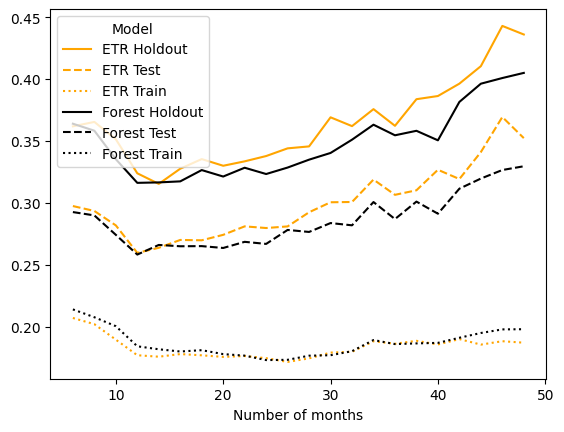

In [69]:
data = pd.DataFrame(results,columns=['Model','MAE%','Number of Months'])
data = data.set_index(['Number of Months','Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of months'
data.plot(color=['orange']*3+['black']*3,style=['-','--',':']*3)
print(data.idxmin())

## Adaptive Boosting

In [70]:
X_train, Y_train, X_test, Y_test = datasets(df_filtered, x_len=12, y_len=1, test_loops=12)

base_estimator: This is the weak learner we want to boost. We will use a tree with a specified max_depth.
n_estimators: The number of weak learners generated.
learning_rate: A coeffivient that reduces the overall impact of each weak model on the weightimg of the training set.
loss: The loss function when updating the weight allocation given to each sample before reshuffling.

Learning Rate: The higher the learning rate the more risk we show for overfitting. It is always better to increase the number of estimators and reduce the learning rate proportionally. But this results in a long training time.  
Loss Function: Loss function is used to compute each weak learners error against the training set to update its weight.
Base Estimator: The deeper tree results in more more overfit.

In [71]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100, learning_rate=0.25, loss ='square')
ada = ada.fit(X_train, Y_train)

Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='AdaBoost')

,MAE,RMSE,Bias
AdaBoost,,,
Train,20.264,28.995,-3.573
Test,39.020,92.127,-6.426


### Parameter Optimization

In [72]:
n_estimators =[20,40,60,80,100]
learning_rate = [0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
loss = ['square','exponential','linear']
param_dist = {'n_estimators': n_estimators,
 'learning_rate': learning_rate,
 'loss':loss}

In [73]:
from sklearn.model_selection import RandomizedSearchCV
results = []
for max_depth in range(2,18,2):
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth))
    ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs=-1, cv=6, n_iter=20, scoring='neg_mean_squared_log_error')
    ada_cv.fit(X_train, Y_train)
    print('Tuned AdaBoost Parameters:', ada_cv.best_params_)
    print('Result:',ada_cv.best_score_)
    results.append([ada_cv.best_score_,ada_cv.best_params_,max_depth])


Tuned AdaBoost Parameters: {'n_estimators': 40, 'loss': 'exponential', 'learning_rate': 0.005}
Result: -2.4587775896564366
Tuned AdaBoost Parameters: {'n_estimators': 60, 'loss': 'square', 'learning_rate': 0.005}
Result: -1.5342851167200526
Tuned AdaBoost Parameters: {'n_estimators': 20, 'loss': 'square', 'learning_rate': 0.01}
Result: -1.293065738109459
Tuned AdaBoost Parameters: {'n_estimators': 40, 'loss': 'square', 'learning_rate': 0.005}
Result: -1.1766222143249427
Tuned AdaBoost Parameters: {'n_estimators': 60, 'loss': 'square', 'learning_rate': 0.01}
Result: -1.0959155690190274
Tuned AdaBoost Parameters: {'n_estimators': 100, 'loss': 'square', 'learning_rate': 0.01}
Result: -1.1234275029799814
Tuned AdaBoost Parameters: {'n_estimators': 80, 'loss': 'square', 'learning_rate': 0.01}
Result: -1.1319347147994943
Tuned AdaBoost Parameters: {'n_estimators': 100, 'loss': 'exponential', 'learning_rate': 0.01}
Result: -1.1762560839296758


In [74]:
results = pd.DataFrame(data=results, columns=['Score', 'Best Params', 'Max Depth'])
optimal =results['Score'].idxmax()
print(results.iloc[optimal])

Score                                                  -1.095916
Best Params    {'n_estimators': 60, 'loss': 'square', 'learni...
Max Depth                                                     10
Name: 4, dtype: object


In [75]:

ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=14),n_estimators=20,learning_rate=0.005,loss='linear')
ada = ada.fit(X_train,Y_train)
Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='AdaBoost Optimized')

,MAE,RMSE,Bias
AdaBoost Optimized,,,
Train,6.574,14.262,0.533
Test,36.124,99.086,-15.556


Model seems to be overfitting the data as the train set has very low error where as the test set has very high.

## Extreme Gradient Boosting

In [ ]:
! pip install xgboost

In [ ]:

from xgboost.sklearn import XGBRegressor
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
XGB = XGB.fit(X_train, Y_train)

In [ ]:
import xgboost as xgb
XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]
xgb.plot_importance(XGB, importance_type='total_gain', show_values=False)

Just like AdaBoost, XGBoost unfortunately cannot forecast multiple periods at once, so we use MultiOutputRegressor.


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
# training and testing
X_train, Y_train, X_test, Y_test = datasets(df_filtered, x_len=12, y_len =6, test_loops=12)
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100, learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train, Y_train)



### Early Stopping  
After a while each new dataset will increase the error rather than decreasing, this is when we stop adding new trees. Early stopping technique will help us avoid overfitting our model to the training set at the sate time reduce training time.

eval_set: The evaluation set is used to evaluate the model after every iteration.  
early_stopping_rounds: The max number of iterations the model can perform without improving the accuracy on the eval_set.  
eval_metric: The metric used the evaluate the eval_set.  

In [29]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split data
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

# Define model
XGB = XGBRegressor(
    n_jobs=-1, 
    max_depth=10, 
    n_estimators=1000, 
    learning_rate=0.01,
     eval_metric=['rmse','mae'],
    early_stopping_rounds=50
    , random_state=42
)

# Fit with early stopping and eval logging
XGB.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    verbose=20                  
)

print(f'Best iteration: {XGB.best_iteration}')
print(f'Best score: {XGB.best_score}')



[0]	validation_0-rmse:74.19315	validation_0-mae:49.85477	validation_1-rmse:72.30378	validation_1-mae:50.28444
[20]	validation_0-rmse:62.44502	validation_0-mae:41.88950	validation_1-rmse:61.88471	validation_1-mae:42.81295
[40]	validation_0-rmse:52.85840	validation_0-mae:35.38093	validation_1-rmse:53.68267	validation_1-mae:36.84609
[60]	validation_0-rmse:45.03623	validation_0-mae:30.04265	validation_1-rmse:47.45675	validation_1-mae:32.16157
[80]	validation_0-rmse:38.63440	validation_0-mae:25.67068	validation_1-rmse:42.64309	validation_1-mae:28.43344
[100]	validation_0-rmse:33.38917	validation_0-mae:22.06396	validation_1-rmse:39.05798	validation_1-mae:25.49509
[120]	validation_0-rmse:29.11900	validation_0-mae:19.14054	validation_1-rmse:36.46944	validation_1-mae:23.20306
[140]	validation_0-rmse:25.69134	validation_0-mae:16.79634	validation_1-rmse:34.70365	validation_1-mae:21.45259
[160]	validation_0-rmse:22.89594	validation_0-mae:14.88947	validation_1-rmse:33.42382	validation_1-mae:20.1204

### Parameter Optimization

subsample: This is the percentage of training sample each tree is fitted on.  
colsample_bynode: This is the maximum number of features a tree can choose from whenit split it has to split a node.  
colsample_bylevel: This is the subsample ratio of features when it has a node.
colsample_bytree: This is just like colsample_bynode, and colsample_bylevel but applied for a whole tree.
min_child_weigth :This is the minimu sume of sample weight each leaf has to contain.
reg_alpha, reg_labmda : Those are the regularization terms in the gradient boosting loss function.

In [30]:
params = {'max_depth': [5,6,7,8,10,11],
 'learning_rate': [0.005,0.01,0.025,0.05,0.1,0.15],
 'colsample_bynode': [0.5,0.6,0.7,0.8,0.9,1.0],#max_features
 'colsample_bylevel': [0.8,0.9,1.0],
 'colsample_bytree': [0.6,0.7,0.8,0.9,1.0],
 'subsample': [0.5,0.6,0.7, 0.8, 0.9,1.0],#max_samples
 'min_child_weight': [5,10,15,20,25],#min_samples_leaf
 'reg_alpha': [1,5,10,20,50],
 'reg_lambda': [0.1,0.5,0.75,0.9,1],
 'n_estimators':[100,300, 500 ,700, 900, 1000]}

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define base model
XGB = XGBRegressor(n_jobs=1,early_stopping_rounds =100,     eval_metric='mae', random_state=42)

# Define search
XGB_cv = RandomizedSearchCV(
    XGB,
    param_distributions=params,
    cv=5,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)


# Fit with early stopping
XGB_cv.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],

    verbose=False
)

print('Tuned XGBoost Parameters:', XGB_cv.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuned XGBoost Parameters: {'subsample': 0.5, 'reg_lambda': 0.75, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0, 'colsample_bylevel': 0.8}


In [32]:
# Extract best params
best_params = XGB_cv.best_params_

# Add early stopping & eval_metric in constructor
XGB = XGBRegressor(
    n_jobs=-1,
    **best_params,
    early_stopping_rounds=25,  
    eval_metric='mae'
)

# Fit with eval_set (validation)
XGB.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    verbose=False
)

# Best iteration and score
print(f'Best iteration: {XGB.best_iteration}')  
print(f'Best score: {XGB.best_score}')

# Predictions
Y_train_pred = XGB.predict(X_train)
Y_test_pred = XGB.predict(X_test)

# Evaluate
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='XGBoost')


Best iteration: 451
Best score: 15.986550716900375


,MAE,RMSE,Bias
XGBoost,,,
Train,16.259,30.478,-0.302
Test,36.045,92.103,-11.574


## Feature Optimization

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

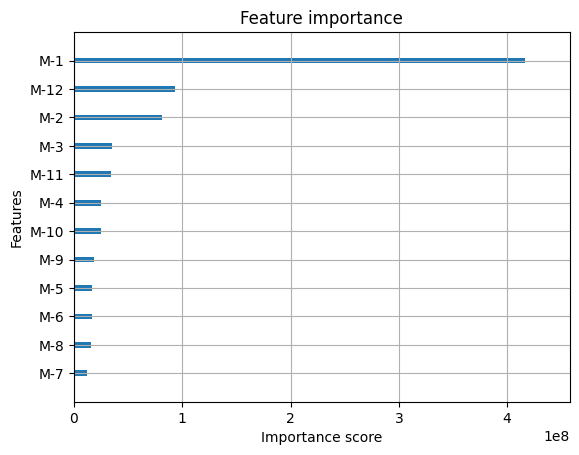

In [76]:
import xgboost as xgb
XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]
xgb.plot_importance(XGB, importance_type='total_gain', show_values=False)

So far we see that XGB gives the best performance on the dataset with optimized parameter values and thus we will try to use feature selection techniques with these parameters to improve performance.

## Feature Selection

In [96]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.feature_selection import SequentialFeatureSelector as SFS

# ✅ Give feature names starting from 1
feature_names = [f"M{i}" for i in range(1, x_train.shape[1] + 1)]

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

XGB = XGBRegressor(
    n_jobs=-1,
    **best_params,
    random_state=42
)

# ----------------------------
# Forward Selection
sfs_forward = SFS(
    XGB,
    n_features_to_select="auto",   # can also be an int like 10
    direction="forward",
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)
sfs_forward.fit(X_train, Y_train)

forward_features = X_train.columns[sfs_forward.get_support()].tolist()
print("Forward selection chosen features:", forward_features)
XGB = XGBRegressor(
    n_jobs=-1,
    **best_params,
    random_state=42
)

XGB.fit(X_train[forward_features], Y_train)

y_train_pred_forward = XGB.predict(X_train[forward_features])
y_test_pred_forward = XGB.predict(X_test[forward_features])


Forward selection chosen features: ['M1', 'M2', 'M3', 'M10', 'M11', 'M12']


'\n# ----------------------------\n# Backward Selection\nsfs_backward = SFS(\n    XGB,\n    n_features_to_select="auto",\n    direction="backward",\n    scoring="neg_mean_absolute_error",\n    cv=5,\n    n_jobs=-1\n)\nsfs_backward.fit(x_train, y_train)\n\nbackward_features = x_train.columns[sfs_backward.get_support()].tolist()\nprint("Backward selection chosen features:", backward_features)\n\nXGB_backward = XGBRegressor(n_jobs=-1, **best_params, eval_metric="mae")\nXGB_backward.fit(x_train[backward_features], y_train)\n\ny_train_pred_backward = XGB_backward.predict(X_train[backward_features])\ny_test_pred_backward = XGB_backward.predict(X_test[backward_features])\n'

In [97]:
kpi_ML(Y_train, y_train_pred_forward, Y_test, y_test_pred_forward, name='XGBoost-forward')

,MAE,RMSE,Bias
XGBoost-forward,,,
Train,14.827,26.046,-0.016
Test,36.354,94.564,-12.735


In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.feature_selection import SequentialFeatureSelector as SFS

# ✅ Give feature names starting from 1
feature_names = [f"M{i}" for i in range(1, x_train.shape[1] + 1)]

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

XGB = XGBRegressor(
    n_jobs=-1,
    **best_params,
    random_state=42
)

# ----------------------------
# Forward Selection
sfs_backward = SFS(
    XGB,
    n_features_to_select="auto",   # can also be an int like 10
    direction="backward",
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)
sfs_backward.fit(X_train, Y_train)

backward_features = X_train.columns[sfs_backward.get_support()].tolist()
print("backward selection chosen features:", backward_features)
XGB = XGBRegressor(
    n_jobs=-1,
    **best_params,
    random_state=42
)

XGB.fit(X_train[backward_features], Y_train)

y_train_pred_backward = XGB.predict(X_train[backward_features])
y_test_pred_backward = XGB.predict(X_test[backward_features])

In [ ]:
kpi_ML(Y_train, y_train_pred_backward, Y_test, y_test_pred_backward, name='XGBoost-backward')